[parte-1]: {filename}captura-de-dados-da-sao-silvestre-com-python.md
[parte-2]: {filename}captura-de-dados-da-sao-silvestre-com-python-parte-2.Rmd

Dando sequência a série de posts onde eu faço a análise do *dataset* de campeões da Corrida de São Silvestre, vou desenvolver a análise exploratória através de gráficos que me ajudam e compreender melhor os dados e a levantar algumas questões interessantes como o desempenho da participação dos quenianos a partir da década de 90.

Mostro como este *dataset* foi construído no post [Captura de dados da Corrida de São Silvestre com Python—Parte 1][parte-1] e faço o tratamento e limpeza dos dados no post [Captura de dados da Corrida de São Silvestre com Python—Parte 2][parte-2].

Lembrando que o objetivo disso tudo é entender como o clima pode influenciar o desempenho dos corredores.
Na [Parte 2][parte-2] dessa sequência eu criei a variável `pace` mas não disse porque.
O `pace` é uma medida relativa que relaciona o `percurso` com o `tempo`, ou seja, é uma forma diferente de expressar a velocidade do corredor, também poderia ter utilizado a velocidade em km/min ou km/h, mas o `pace` é mais comum entre os corredores.
Não poderia utilizar apenas o `tempo` porque o ele depende do `percurso`, e quanto maior o percurso maior o tempo, logo isso compromete qualquer comparação que eu queira fazer.
A idéia neste post é explorar os dados, entender o seu comportamento e como posso trabalhar com eles para tentar responder a pergunta colocada.
Para isso eu vou observar o comportamento do `pace` e verificar como ele se dá quando considero o `sexo`, mas antes vou apresentar uma contagem simples dos dados dos campeões que mostra como é possível extrair informações interessantes de um *dataset* simples como este.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sb
sb.set_context("talk")
import sys
print('python', sys.version)
print('pandas', pd.__version__)
print('statsmodels', sm.version.full_version)

Populating the interactive namespace from numpy and matplotlib
python 3.4.1 (default, May 19 2014, 13:10:29) 
[GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
pandas 0.16.0
statsmodels 0.6.1


## Carregando os dados limpos e formatados

Começo carregando o arquivo CSV `saosilvestre-lf.csv` que são os dados limpos e formatados produzidos no último [post]({filename}captura-de-dados-da-sao-silvestre-com-python-parte-2.Rmd). O *dataset* está limpo e formatado, os campos de data já estão no formato ISO e as colunas `tempo` e `pace` estão em decimais que representam os minutos.

In [2]:
ss = pd.read_csv("https://raw.githubusercontent.com/wilsonfreitas/saosilvestre/master/saosilvestre-lf.csv")

Vou remover as colunas: `largada`, `chegada` e `horario`; elas não vão me ser úteis aqui e além do mais poluem a vizualização.

In [3]:
ss = ss.drop(['largada', 'chegada', 'horario'], 1)
ss.head()

,nome,pais,corrida,ano,tempo,percurso,data,pace,sexo
0,Alfredo Gomes,Brasil,1,1925,23.166667,6200,1925-12-31 12:00:00,3.736559,masculino
1,Jorge Mancebo,Brasil,2,1926,22.533333,6200,1926-12-31 12:00:00,3.634409,masculino
2,Heitor Blasi,Itália,3,1927,23.000000,6200,1927-12-31 12:00:00,3.709677,masculino
3,Salim Maluf,Brasil,4,1928,29.183333,8800,1928-12-31 12:00:00,3.316288,masculino
4,Heitor Blasi,Itália,5,1929,29.183333,8800,1929-12-31 12:00:00,3.316288,masculino


## Explorando os dados

O *dataset* tem registros de campeões da Corrida de São Silvestre desde 1925, acredito que o primeiro ano da prova, com o tempo, sexo, país, distância do percurso e ano.
Quando eu pego um *dataset* eu gosto de contar ocorrências, montar um histograma das variáveis, ou seja, entender o que eu tenho em mãos.

Dessa maneira a primeira ideia é contar a quantidade de campeões por país, ou seja, fazem um histograma por `pais` que seria uma variável categórica.
No entanto, tenho a coluna `sexo` e gostaria de ver essa contagem agrupada por sexo.
Gostaria ainda que em caso de empate, o país com maior quantidade de campeões masculinos viesse na frente.

Para fazer isso com o pandas eu preciso agrupar os dados por `pais` e `sexo`, fazer a contagem da variável `sexo`, isto é, sexo por país, calcular o total de campeões somando as quantidade de campeões por sexo e finalmente ordenar pelo total e pela quantidade de campeões homens antes de fazer o gráfico.

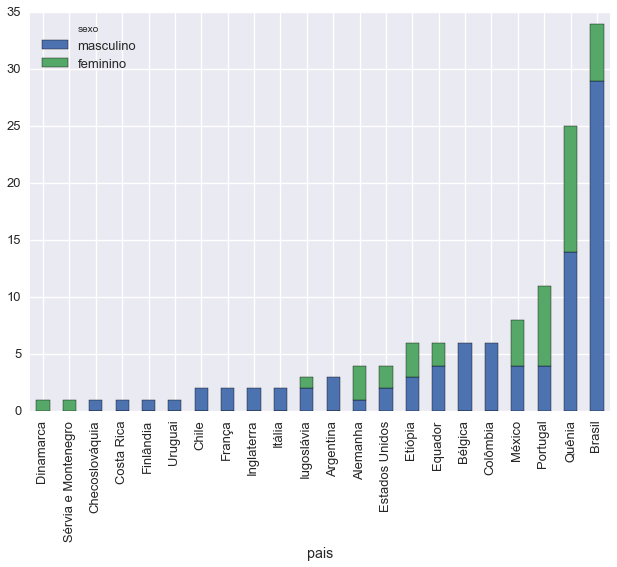

In [4]:
ss_pais = ss.groupby(['pais', 'sexo'])\
    .sexo\
    .count()\
    .unstack()\
    .fillna(0)
ss_pais['total'] = ss_pais['masculino'] + ss_pais['feminino']
ss_pais.sort(['total', 'masculino'], inplace=True)
ss_pais[['masculino', 'feminino']].plot(kind='bar', stacked=True);

Este é o gráfico com as quantidades agrupadas por sexo empilhadas, que apresenta exatamente um histograma da quantidade de campeões por país, trazendo a separação por sexo.
Mas se as barras fossem de apenas 1 cor eu teria apenas o histograma de campeões.

O desempenho do Brasil é bom porque tem a maior taxa de participação na prova, diferente do Quênia que começou a marcar presença recentemente.

Outra forma de olhar o mesmo gráfico é colocando as barras lado a lado e assim é possível observar que apenas Portugal e Alemanha possuem mais campeãs que campeões e que México, Etiópia e Estados Unidos possuem quantidades iguais de campeões por sexo.
Novamente fica claro que o Brasil possui um número excepcional de campeões porque realiza essa prova desde 1925 e se separar este gráfico por sexo, no feminino o Brasil cai para a terceira posição.

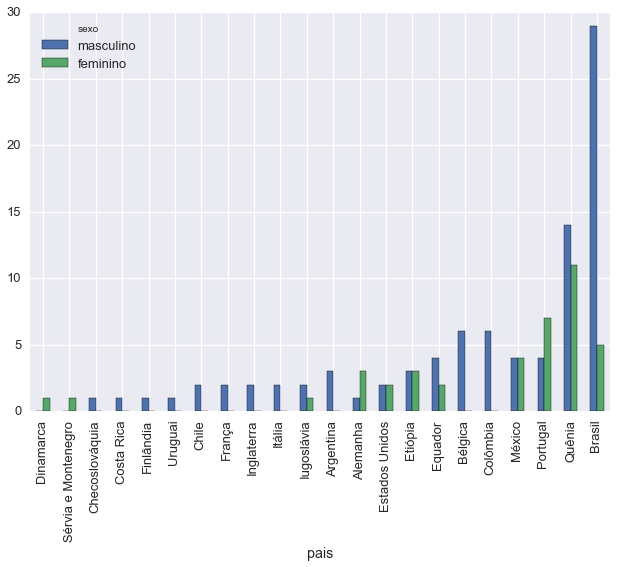

In [5]:
ss_pais[['masculino', 'feminino']].plot(kind='bar', stacked=False);

### Evolução dos campeões ao longo dos anos

Outra coisa interessante de fazer é avaliar a evolução dos campeões por país ao longo dos anos.
A ideia é fazer a contagem acumulada dos campeões ao longo dos anos.

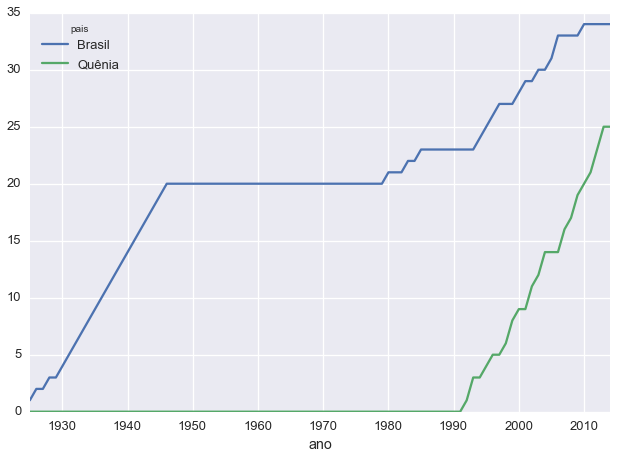

In [6]:
ss.groupby(['ano', 'pais'])\
    .corrida\
    .count()\
    .unstack()[['Brasil', 'Quênia']]\
    .fillna(0)\
    .cumsum()\
    .plot();

Observando o gráfico acima vemos que o Brasil ficou quase 3 décadas sem campeões, voltando a acumular vitórias nos anos 80.
Quênia começou a colecionar vitórias na década de 90 e desde então vem em um crescente aumento de vitórias.
Observando as tendências destas curvas vejo que o coeficiente de crescimento do Quênia é maior do que do Brasil, indicando que em algum momento este país ultrapassará o Brasil em quantidade de campeões da corrida.

Vou separar os dados de Brasil e Quênia a partir de 1990, ano em que Quênia começou a ter vitórias, e tentar fazer uma previsão do ano em que o Quênia ultrapassará o Brasil em quantidade de vitórias, com base nestas tendências.
Dessa forma vou ficar com 2 *datasets* e vou ajustar uma reta para cada conjunto de dados.
O objetivo é extrapolar a tendência de vitórias dos países e tentar prever o ano em que as retas se cruzam, indicando que o Quênia atingiu a mesma quantidade de vitórias do Brasil.

In [7]:
ss_vic = ss.groupby(['ano', 'pais'])\
    .corrida\
    .count()\
    .unstack()\
    .fillna(0)\
    .cumsum()

ss_vic_br = ss_vic.loc[ss_vic.index > 1990, 'Brasil']
ss_vic_qn = ss_vic.loc[ss_vic.index > 1990, 'Quênia']

def fit(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    return model.fit()

fit_br = fit(ss_vic_br.index.values, ss_vic_br.values)
fit_qn = fit(ss_vic_qn.index.values, ss_vic_qn.values)

O ajuste das retas me dá os coeficientes das equações do primeiro grau que representam as vitórias acumuladas em função dos anos.
Para saber o ano em que Quênia ultrapassará o Brasil é necessário igualar as equações e calcular o ano.

In [8]:
diff = fit_br.params - fit_qn.params
print("Ano = {0}".format(int(-diff[0]/diff[1])))

Ano = 2035


De acordo com as retas ajustadas o ano será próximo de 2035.
Ainda poderíamos incluir a variância dos coeficientes na conta e estimar a incerteza sobre esta estimativa.

Apenas para melhor ilustrar o que acabei de calcular vou criar um gráfico com os pontos e as retas e extrapolar as retas até 2040 para observar o ponto de cruzamento.

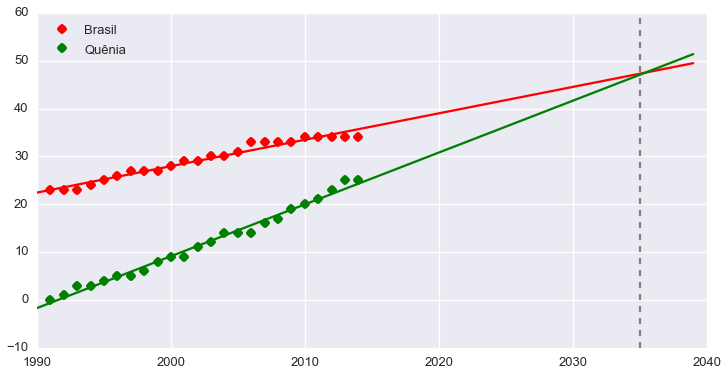

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

x, y = fit_br.model.data.exog[:,1], fit_br.model.data.endog
ax.plot(x, y, 'ro', label="Brasil")

x = np.arange(1990, 2040)
y = fit_br.params[0] + fit_br.params[1]*x
ax.plot(x, y, 'r-')

x, y = fit_qn.model.data.exog[:,1], fit_qn.model.data.endog
ax.plot(x, y, 'go', label="Quênia")

x = np.arange(1990, 2040)
y = fit_qn.params[0] + fit_qn.params[1]*x
ax.plot(x, y, 'g-')

ax.axvline(2035, color='grey', linestyle='dashed')

ax.legend(loc='best');

Como é possível observar, as retas cruzam-se próximo de 2035.

## Conclusão

Foi possível observar com este simples *dataset* como utilizar ferramentas de visualização e regressão para extrair um pouco do que os dados tem a dizer.
Consegui enxergar a distribuição de campeões de 2 formas diferentes, podendo assim identificar aspectos diferentes na distribuição de campeões.
A análise de evolução dos dados permitiu fazer uma previsão, onde considerando o histórico observado foi possível prever que próximo de 2035 teremos o Quênia com uma maior quantidade de vitórias na corrida de São Silvestre, obviamente se estas tendências se mantiverem.

Gosto de ver como é possível extrair informações relevantes com análises simples em *datasets* que cabem na memória do computador.
Essa abordagem pode ser reproduzida mesmo para grandes conjuntos de dados onde uma amostra pode ser separada e analisada independentemente.
A idéia de trabalhar com conjuntos de dados gigantes é um passo posterior, quando algumas hipóteses já foram levantadas em amostras menores.
Para explorar os dados ferramentas visuais são muito interessantes, tem muita gente gerando bons resultados com Excel, eu particularmente não gosto.
Na análise de dados é preciso ter parsimônia para saber interpretar o que os dados têm a dizer.